In [1]:
import numpy as np
import nengo
import scipy
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join('..', 'scripts'))
import figure_utils as utils
import lif_utils
from sspspace import HexagonalSSPSpace,SSPSpace

In [3]:
dat = scipy.io.loadmat('../data/11084-10030502_t4c1.mat')
path = np.hstack([dat['x1'], dat['y1']])
path = path[np.all(np.isfinite(path),axis=1),:]
pathscale =  np.max(path)
path = path/pathscale
dt = 0.002
view_rad=0.4

domain_dim = 2
bounds = np.tile([-1,1],(domain_dim,1))
ssp_space = HexagonalSSPSpace(domain_dim,n_scales = 5,n_rotates=4, 
                 scale_min=0.9, scale_max=3,
                 domain_bounds=bounds, length_scale=0.2)
d = ssp_space.ssp_dim

ssp_path = ssp_space.encode(path)
fssp_path = ssp_space.encode_fourier(path)

pathlen = path.shape[0]
timesteps = np.arange(0,dt*pathlen,dt)
T = timesteps[-1]

vels = (1/dt)*( path[(np.minimum(np.floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
               path[(np.minimum(np.floor(timesteps/dt), pathlen-2)).astype(int),:])
real_freqs = (ssp_space.phase_matrix @ vels.T)
scale_fac = 1/np.max(np.abs(real_freqs))
vels_scaled = vels*scale_fac


In [4]:


obj_locs = np.array([[0.4,-0.5], [-0.2,0.4]])
obj_ssp = ssp_space.encode(obj_locs)
wall_xs = np.linspace(0.9,1,2)
wall_ys = np.linspace(-1,1,20)
wall_locs = np.meshgrid(wall_xs,wall_ys)
wall_locs2 = np.vstack([wall_locs[0].reshape(-1), wall_locs[1].reshape(-1)]).T
wall_ssp = ssp_space.normalize(np.sum(ssp_space.encode(wall_locs2), axis=0))
wall_fssps = np.fft.fft(wall_ssp)

n_neurons = 800
G_encoders = ssp_space.sample_grid_encoders(n_neurons)

n_rads = int(np.sqrt(n_neurons))
n_thetas = int(n_neurons/n_rads)
rads = np.linspace(0.1, 0.4, n_rads)
thetas = np.linspace(0, 2*np.pi, n_thetas)
R,T = np.meshgrid(rads,thetas)
R = R.reshape(-1)
T = T.reshape(-1)
OVC_vectors = np.vstack([R*np.cos(T),R*np.sin(T)]).T
OVC_encoders = ssp_space.encode(OVC_vectors)
n_OVCs = OVC_encoders.shape[0]
BC_encoders =OVC_encoders
n_BCs = BC_encoders.shape[0]

PC_encoders,pc_locs = ssp_space.get_sample_pts_and_ssps(n_neurons,method='sobol')

/home/ns2dumon/anaconda3/envs/nengo-env/lib/python3.9/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [5]:
def vision_ssp_fun1(t):
    deltaS = np.zeros(d)
    S = fssp_path[int(t/dt)-1,:]
    any_objs = False
    for i in range(2):
        vec = obj_locs[i,:] - path[int(t/dt)-1,:]
        if np.linalg.norm(vec) <= view_rad:
            deltaS = ssp_space.encode(vec)
            any_objs = True
    if any_objs:
        deltaS = ssp_space.normalize(deltaS)
    return deltaS.reshape(-1)

def vision_ssp_fun2(t):
    deltaS = np.zeros(d)
    S = fssp_path[int(t/dt)-1,:]

    closestX = np.clip(path[int(t/dt)-1,0],0.9,1)
    closestY = np.clip(path[int(t/dt)-1,1],-1,1)
    dist_to_wall = np.sqrt((closestX - path[int(t/dt)-1,0])**2 + (closestY - path[int(t/dt)-1,1])**2)
    if dist_to_wall <= view_rad:
        deltaS = np.fft.ifft( ssp_space.make_unitary_fourier(wall_fssps) / S)
        deltaS = ssp_space.normalize(deltaS)
    return deltaS.reshape(-1)
    
model = nengo.Network(seed=11)
with model:
    inpt = nengo.Node(lambda t: ssp_space.encode( path[int(t/dt)-1,:].reshape(1,-1) ).flatten() )
    gcs = nengo.Ensemble(n_neurons, dimensions=d,encoders = G_encoders,max_rates = nengo.dists.Uniform(20, 40),
                         intercepts = nengo.dists.Uniform(-0.2,0.4))
    nengo.Connection(inpt, gcs, synapse=None)
    
    pcs = nengo.Ensemble(n_neurons, dimensions=d,encoders = PC_encoders,max_rates = nengo.dists.Uniform(20, 40),
                         intercepts = nengo.dists.Uniform(0.,0.4))
    nengo.Connection(inpt, pcs, synapse=None)
    
    
    dssp_in = nengo.Node(lambda t: vision_ssp_fun1(t))
    ovcs = nengo.Ensemble(n_OVCs, dimensions=d,encoders = OVC_encoders,max_rates = nengo.dists.Uniform(20, 40),
                         intercepts = nengo.dists.Uniform(-0.2,0.4))
    nengo.Connection(dssp_in, ovcs, synapse=None)
    
    dssp2_in = nengo.Node(lambda t: vision_ssp_fun2(t))
    bcs = nengo.Ensemble(n_BCs, dimensions=d,encoders = BC_encoders,max_rates = nengo.dists.Uniform(20, 40),
                         intercepts = nengo.dists.Uniform(-0.2,0.4))
    nengo.Connection(dssp2_in, bcs, synapse=None)
    
    ens_p = nengo.Probe(gcs, synapse=0.05)
    gc_n_p = nengo.Probe(gcs.neurons, synapse=None)
    pc_n_p = nengo.Probe(pcs.neurons, synapse=None)
    ovc_n_p = nengo.Probe(ovcs.neurons, synapse=None)
    bc_n_p = nengo.Probe(bcs.neurons, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(timesteps[-1])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/ns2dumon/anaconda3/envs/nengo-env/lib/python3.9/site-packages/nengo/builder/operator.py:826: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


Text(0.82, 0.75, 'Border cell')

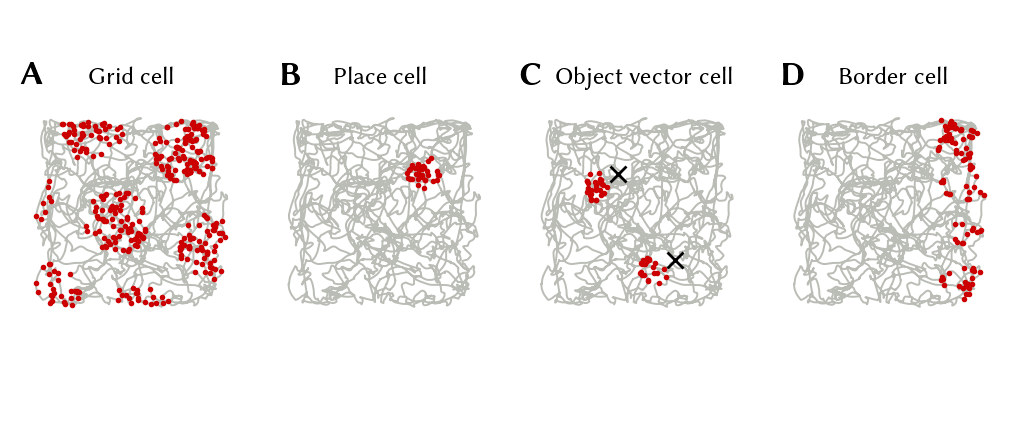

In [6]:
sim_path = np.repeat(path[:-1,:],int(0.002/sim.dt),axis=0)

idx1=117
idx2 = 3
idx3 = 74 
idx4 = 179 

fig = plt.figure(figsize=(6.25, 2.5))#5.4,2.5))
ax1 = fig.add_subplot(141)
ax1.plot(path[:,0],path[:,1],zorder=1,color=utils.grays[3],linewidth=0.7)
spike_pts = sim.data[gc_n_p][:,idx1]>0
ax1.scatter(sim_path[spike_pts,0],sim_path[spike_pts,1], 1,color=utils.reds[1],zorder=2)
ax1.axis('off')
ax1.axis('equal')

ax2 = fig.add_subplot(142)
ax2.plot(path[:,0],path[:,1],zorder=1,color=utils.grays[3],linewidth=0.7)
spike_pts = sim.data[pc_n_p][:,idx2]>0
ax2.scatter(sim_path[spike_pts,0],sim_path[spike_pts,1], 1,color=utils.reds[1],zorder=2)
ax2.axis('off')
ax2.axis('equal')

ax3 = fig.add_subplot(143)
ax3.plot(path[:,0],path[:,1],zorder=1,color=utils.grays[3],linewidth=0.7)
spike_pts = sim.data[ovc_n_p][:,idx3]>0
ax3.scatter(sim_path[spike_pts,0],sim_path[spike_pts,1], 1,color=utils.reds[1],zorder=2)
ax3.plot(obj_locs[0,0],obj_locs[0,1],'x',color='k')
ax3.plot(obj_locs[1,0],obj_locs[1,1],'x',color='k')
ax3.axis('off')
ax3.axis('equal')

ax3 = fig.add_subplot(144)
ax3.plot(path[:,0],path[:,1],zorder=1,color=utils.grays[3],linewidth=0.7)
spike_pts = sim.data[bc_n_p][:,idx4]>0
ax3.scatter(sim_path[spike_pts,0],sim_path[spike_pts,1], 1,color=utils.reds[1],zorder=2)
ax3.axis('off')
ax3.axis('equal')


fig.text(0.12, 0.75, '\\textbf{A}', size=12, va="baseline", ha="left")
fig.text(0.33,0.75, '\\textbf{B}', size=12, va="baseline", ha="left")
fig.text(0.52,0.75, '\\textbf{C}', size=12, va="baseline", ha="left")
fig.text(0.73,0.75, '\\textbf{D}', size=12, va="baseline", ha="left")

fig.text(0.21, 0.75, "Grid cell", va="baseline", ha="center")
fig.text(0.41, 0.75, "Place cell", va="baseline", ha="center")
fig.text(0.62, 0.75, "Object vector cell", va="baseline", ha="center")
fig.text(0.82, 0.75, "Border cell", va="baseline", ha="center")

# utils.save(fig, "many_cells_v2.pdf")